<center> <h1> User Spending Prediction - Model Building </h1> </center>

In [63]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.losses import Huber
from keras.layers import Dropout

In [2]:
user_df = pd.read_csv('processed data/userx.csv')

In [3]:
user_df

,InvoiceDate,Quantity,Price
0,2009-12-02 15:41:00,11,2.10
1,2009-12-02 15:41:00,1,2.10
2,2009-12-02 15:41:00,1,1.95
3,2009-12-02 15:41:00,1,3.75
4,2009-12-02 15:41:00,3,12.75
...,...,...,...
12633,2011-12-08 12:07:00,1,1.95
12634,2011-12-08 12:07:00,3,0.85
12635,2011-12-08 12:07:00,12,0.42
12636,2011-12-08 12:07:00,1,4.25


In [4]:
user_df['InvoiceDate'] = pd.to_datetime(user_df['InvoiceDate'])  
user_df.set_index('InvoiceDate', inplace=True)  

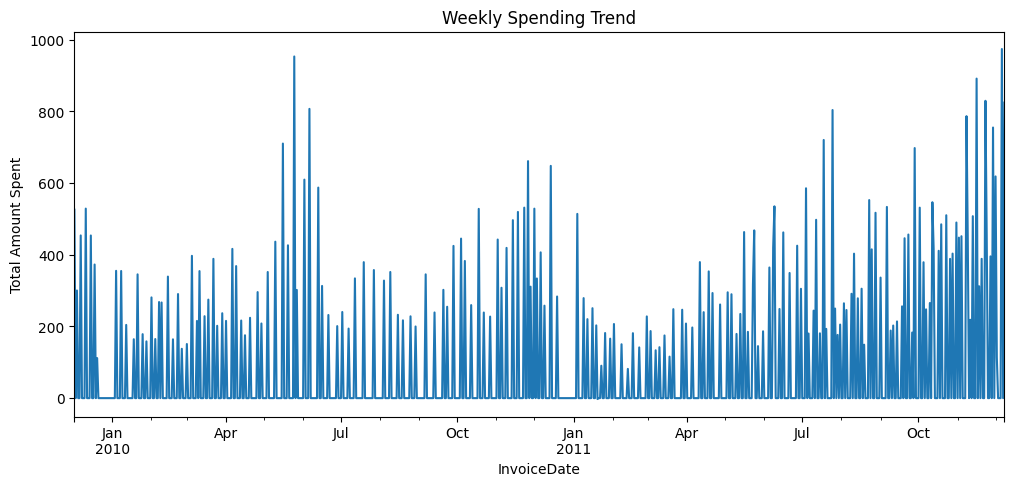

In [51]:
user_df['TotalAmount'] = user_df['Quantity'] * user_df['Price']
weekly_spending = user_df['TotalAmount'].resample('D').sum()
weekly_spending.plot(title='Weekly Spending Trend', figsize=(12, 5))
plt.ylabel('Total Amount Spent')
plt.show()


In [52]:
# Nomalizing Data for Training
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(weekly_spending.values.reshape(-1, 1))

In [53]:
# Converting the dataframe value to sequences of 4 for tensorflow input layer
# X = [wk1,wk2,wk3,wk4]
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 4
X, y = create_sequences(scaled_data, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1)) 

In [54]:
X.shape

(733, 4, 1)

In [55]:
split = int(len(X) * 0.9)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [64]:
lookback = 5
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(16),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss=Huber(delta=1.0))
model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))


/mnt/Data/Projects/User-Expenses-Prediction/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0150 - val_loss: 0.0501
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0120 - val_loss: 0.0485
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0128 - val_loss: 0.0497
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0144 - val_loss: 0.0515
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0128 - val_loss: 0.0503
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0122 - val_loss: 0.0507
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0137 - val_loss: 0.0521
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0117 - val_loss: 0.0487
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0126 - val_loss: 0.0510
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0139 - val_loss: 0.0522
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0141 - val_loss: 0.0526
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


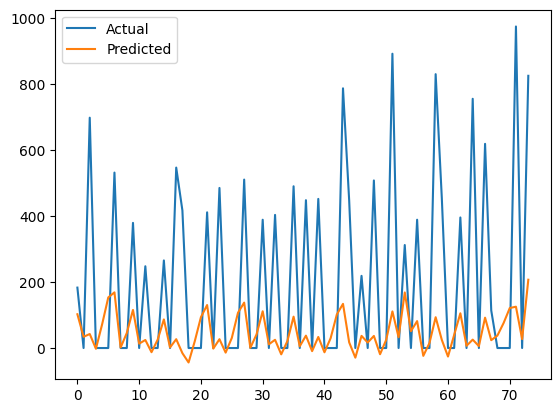

In [65]:
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)
actual = scaler.inverse_transform(y_test)

plt.plot(actual, label='Actual')
plt.plot(predicted, label='Predicted')
plt.legend()
plt.show()


In [66]:
predicted

array([[102.26868   ],
       [ 33.97864   ],
       [ 42.428738  ],
       [ -2.217759  ],
       [ 71.50817   ],
       [153.26024   ],
       [168.6196    ],
       [  1.5304674 ],
       [ 45.527344  ],
       [115.32797   ],
       [ 13.284836  ],
       [ 24.318666  ],
       [-12.63079   ],
       [ 25.503645  ],
       [ 86.60599   ],
       [  1.7732457 ],
       [ 26.764723  ],
       [-15.587637  ],
       [-43.79306   ],
       [ 20.349327  ],
       [ 93.43088   ],
       [130.20174   ],
       [ -1.745793  ],
       [ 26.744453  ],
       [-13.918841  ],
       [ 30.589468  ],
       [106.87136   ],
       [137.56694   ],
       [  0.53020793],
       [ 41.21681   ],
       [111.337296  ],
       [ 11.287573  ],
       [ 24.912762  ],
       [-19.13599   ],
       [ 21.080698  ],
       [ 94.98303   ],
       [  5.2321153 ],
       [ 37.478355  ],
       [ -9.407561  ],
       [ 33.495647  ],
       [-12.907258  ],
       [ 29.886915  ],
       [101.54882   ],
       [133

In [67]:
actual

array([[182.99],
       [  0.  ],
       [697.7 ],
       [  0.  ],
       [  0.  ],
       [  0.  ],
       [531.43],
       [  0.  ],
       [  0.  ],
       [379.09],
       [  0.  ],
       [247.67],
       [  0.  ],
       [  0.  ],
       [265.3 ],
       [  0.  ],
       [546.56],
       [416.78],
       [  0.  ],
       [  0.  ],
       [  0.  ],
       [411.04],
       [  0.  ],
       [484.88],
       [  0.  ],
       [  0.  ],
       [  0.  ],
       [510.21],
       [  0.  ],
       [  0.  ],
       [388.57],
       [  0.  ],
       [403.25],
       [  0.  ],
       [  0.  ],
       [489.95],
       [  0.  ],
       [447.79],
       [  0.  ],
       [451.69],
       [  0.  ],
       [  0.  ],
       [  0.  ],
       [786.69],
       [446.98],
       [  0.  ],
       [218.61],
       [  0.  ],
       [507.59],
       [  0.  ],
       [  0.  ],
       [891.45],
       [  0.  ],
       [312.  ],
       [  0.  ],
       [388.66],
       [  0.  ],
       [  0.  ],
       [829.55